In [1]:
# select the guide stars given a field

import warnings
warnings.filterwarnings("ignore")

import ceo
import yaml
from yaml import Loader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.path.append(os.path.expanduser('~/PYTHON/ATP/'))
from astropy.units import Quantity
from astropy.time import Time
import astropy.io.fits as pyfits
import atp
import copy
from agwsprobes import *
import scipy.interpolate

/home/ubuntu/CEO/python/ceo/zemax


In [2]:
L=25.5
nPx = 201
nLenslet = 48
threshold = 0.5 # subaperture flux threshold
gmt = ceo.GMT_MX()

In [3]:
def modestogmtstate(gmt,modes):
    state = gmt.state

    M1Txyz = modes[[0,1,2,12,13,14,24,25,26,36,37,38,48,49,50,60,61,62,72,73,74]]
    state['M1']['Txyz'] = np.reshape(M1Txyz,(7,3))

    M2Txyz = modes[[6,7,8,18,19,20,30,31,32,42,43,44,54,55,56,66,67,68,77,78,79]]
    state['M2']['Txyz'] = np.reshape(M2Txyz,(7,3))

    M1Rxyz = np.zeros(21)
    M1Rxyz[0:20] = modes[[3,4,5,15,16,17,27,28,29,39,40,41,51,52,53,63,64,65,75,76]]
    state['M1']['Rxyz'] = np.reshape(M1Rxyz,(7,3))
    
    M2Rxyz = np.zeros(21)
    M2Rxyz[0:20] = modes[[9,10,11,21,22,23,33,34,35,45,46,47,57,58,59,69,70,71,80,81]]
    state['M2']['Rxyz'] = np.reshape(M2Rxyz,(7,3))
    gmt^=state

In [4]:
girmode = "tracking"
config = "m3"
maxstarsperprobe = 8 # maximum number of stars per probe to analyze

# this contains information about the observation
cfg = yaml.load(open(os.path.expanduser('~/PYTHON/ATP/atp.yaml')),Loader)

In [5]:
# load the data about the observation
data = pyfits.getdata(os.path.expanduser('~/PYTHON/AGWS/SAO/weather_pointing_data.fits'))
temperature = data[:,0] # Temperature draw in deg C
pressure = data[:,1] # Pressure draw in mbar
humidity = data[:,2] # Relative humidity in %
windspeed = data[:,3] # Wind speed in m/s
winddir = data[:,4] # Wind direction in degrees
datetime = data[:,5] # Date vector (Clay is first 500, Baade is second 500)
scira = data[:,6] # RA vector (degrees; Clay is first 500, Baade is second 500)
scidec = data[:,7] #  Declination vector (degrees; Clay is first 500, Baade is second 500)
telaz = data[:,8] # Azimuth angle of telescope (degrees; Clay is first 500, Baade is second 500)
telel = data[:,9] # Elevation angle of telescope (degrees; Clay is first 500, Baade is second 500)
r0 = data[:,10] # r0 (cm)
L0 = data[:,11] # L0 (m)

validator = agwsinit(config)

# this notebook only looks at the first field.

In [6]:
#the python file loops over all 1000 fields.
fieldno = 0

In [7]:
datetime[0]

2013.3871424086758

In [8]:
telzen = (90-telel[fieldno])*np.pi/180.
airmass = 1./np.cos(telzen)

cfg['Observation']['time'] = Time(datetime[fieldno] , format='decimalyear', scale='utc')
cfg['Target']['ra'] = scira[fieldno]
cfg['Target']['dec'] = scidec[fieldno]

cfg['Target']['pointing alt/az']['alt'][0] = telel[fieldno]
cfg['Target']['pointing alt/az']['az'][0] = telaz[fieldno]

cfg['Atmosphere']['r0'][0] = r0[fieldno]*100.
cfg['Atmosphere']['L0'][0] = L0[fieldno]

obs = atp.Observatory(**cfg['Observatory'],**cfg['Observation'])
target = atp.Target(obs,**cfg['Target'])

In [9]:
fielddir = "~/PYTHON/AGWS/Fields"
starfield = os.path.expanduser(fielddir+f"/field_{fieldno:04d}.csv")

outputfilename = os.path.expanduser('~/')+f'PYTHON/AGWS/Fields/{config}_asterism_{fieldno:04d}.csv'
probefunction = [None,None,None,None]
gsno = [None,None,None,None] # guide star number
vismaggs = [0,0,0,0]
xposgs = [0,0,0,0]
yposgs = [0,0,0,0]

In [10]:
stars  = atp.StarField(obs,target,field=starfield,**cfg['Star Catalog'])

In [11]:
vismag = 0.46*stars.I+0.54*stars.R
# remove stars that have an NaN for magnitude
valid = ~np.isnan(vismag)
validpos = np.where(valid)[0]

xposarcsec = stars.local[0,:]*180./np.pi*3600
yposarcsec = stars.local[1,:]*180./np.pi*3600

In [12]:
print(len(vismag), len(valid))

1887 1887


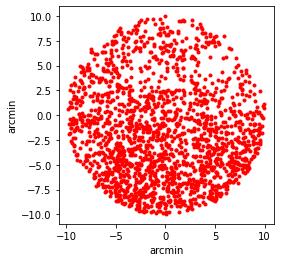

In [13]:
plt.figure(8)
plt.clf()
ax = plt.axes()
ax.set_aspect('equal')
#plt.xlim((-610,610))
#plt.ylim((-610,610))
#plt.plot(xposarcsec[validpos],yposarcsec[validpos],'.',color='red')
plt.plot(xposarcsec[validpos]/60,yposarcsec[validpos]/60,'.',color='red')
plt.xlabel('arcmin')
plt.ylabel('arcmin');

## run agwscheck() to remove invalid stars

In [14]:
gspos = np.transpose(np.array([xposarcsec,yposarcsec]))
for k in range(len(xposarcsec)):
    if valid[k]:
        (success,loc,idx) = agwscheck(validator,gspos[[k],:])
        valid[k] = success

In [15]:
validpos = np.where(valid)[0]
print(len(validpos))

996


In [16]:
if len(validpos) == 0:
    print('There are no guide stars!')
    bestasterism = {'Probe number': [0,1,2,3], 'Probe function': probefunction,'Guide star':gsno,'Visible magnitude':vismaggs,'xpos':xposgs,'ypos':yposgs}

    print(outputfilename)
    df = pd.DataFrame(bestasterism,index=None)
    print (df)
    df.to_csv(outputfilename, index = False, header=True)
    print('PROCEED TO THE NEXT FIELD, SKIP BELOW')

vismag = vismag[validpos]
xposarcsec = xposarcsec[validpos]
yposarcsec = yposarcsec[validpos]

Text(0, 0.5, 'Y-position (arcsec)')

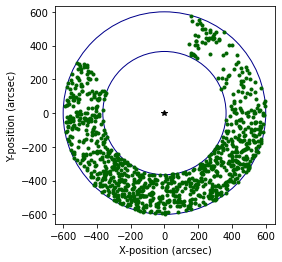

In [17]:
if config == "dgwf":
    minradarcsec = 365 # trial and error
    maxradarcsec = 572.4 # trial and error
if config == "dgnf":
    # the AGWS must be > 6' away to avoid vignetting the field
    minradarcsec = 364.7 
    maxradarcsec = 600
if config == "m3":
    # radius of guide star must be greater than 357.9 mm
    minradarcsec = 365.07
    maxradarcsec = 600

ax = plt.axes()
ax.set_aspect('equal')
plt.plot(xposarcsec,yposarcsec,'.',color='darkgreen')
innercircle = plt.Circle([0,0],radius=minradarcsec,color='darkblue',fill=False)
ax.add_artist(innercircle)
outercircle = plt.Circle([0,0],radius=maxradarcsec,color='darkblue',fill=False)
ax.add_artist(outercircle)
plt.plot([0],[0],'*',color='black')

plt.xlabel('X-position (arcsec)')
plt.ylabel('Y-position (arcsec)')

Note: the shadow of M3 causes no stars between 10 and 12 o'clock in the above figure

In [18]:
gspos = np.transpose(np.array([xposarcsec,yposarcsec]))

# determine which probes reach which stars
probesreachstars = agwsreachstars(validator,gspos)

In [19]:
probesreachstars.shape

(4, 996)

In [20]:
print(probesreachstars)

[[False False False ... False False False]
 [False  True  True ... False False False]
 [False False  True ... False  True  True]
 [ True False False ...  True False  True]]


In [21]:
# select the segment tip-tilt star and the associated probe
# zenith angle in radians (used to find the anisoplanatic error)

# find the star with the lowest segment tip-tilt error
# inputs: distance from center in arcminutes, mV (currently); need to fix
radialdistArcmin = np.hypot(xposarcsec,yposarcsec)/60.

# calculate the seeing 
gs_wavelength = Quantity(*cfg['SH']['guide star']['wavelength']).to('m').value
r0_wavelength = Quantity(*cfg['Atmosphere']['wavelength']).to('m').value
r0_val = Quantity(*cfg['Atmosphere']['r0']).to('m').value
r0_val *= atp.r0_scaling(r0_wavelength,gs_wavelength,telzen)
seeingRad = gs_wavelength/r0_val
seeingArcsec = seeingRad*ceo.constants.RAD2ARCSEC
print("seeing (arcsec) : %5.3f" %seeingArcsec)

seeing (arcsec) : 0.757


### we next determine the best TT7 star, i.e., which star will be measured with the TT7 probe

we do this by predicting the TT7 error for each star

This error has two parts, the noise_rms and aniso_rms.

In [22]:
# TT7 tip-tilt error per subaperture (24x24 subapertures)
# use the interaction matrix to obtain the error in segment tip-tilt
# 

# calculate at what magnitude we saturate and define as minimum magnitude

# calculate the anisoplanatic error by setting magnitude to 0
tt7_aniso_rms = [atp.tt7_tt_error(zz,0.,telzen,**cfg) for zz,magnitude in zip(radialdistArcmin,vismag)]
# calculate the approximate TT7 error
# saturation is attained for magnitude 10 stars
# values calculated using tt7noise.i for 0.8" seeing
magvec = np.array([0,10,10.5,11,11.5,12,12.5,13,13.5,14,14.5,15,15.5,16,16.5,17,17.5,18,20])
# this is the error in the segment tip-tilt estimate using a 24x24 SH WFS
tterr_for_800mas = np.array([0.00204073,0.00204073,0.00248421,0.00313843,0.00404597,0.0052902,0.00649479,
                             0.00812451,0.0108732,0.0140705,0.018404,0.0248977,0.0369819,0.0556996,0.0910204,
                             0.13293,0.179323,0.205629,0.205629])*1000.
tterr_mas = tterr_for_800mas*seeingArcsec/0.8

In [23]:
len(tt7_aniso_rms)

996

In [24]:
len(tterr_mas)

19

In [25]:
interp_function = scipy.interpolate.interp1d(magvec,tterr_mas,bounds_error=False)
tt7_noise_rms = interp_function(np.clip(vismag,np.min(magvec),np.max(magvec)))
tt7_res_rms = tt7_noise_rms + tt7_aniso_rms

In [26]:
tt7_aniso_rms[:5]

[25.492024357344302,
 25.508132547705802,
 25.483575689583954,
 25.52036850341767,
 25.49300028652767]

In [27]:
tt7_res_rms[:10]

array([108.19067803,  54.63790369, 111.50186185, 130.48057022,
       148.57253341,  50.22314332, 122.9331587 ,  27.47479203,
        74.20456505,  65.60268822])

#### for now, we will use the best TT7 star, but later we could also try the other stars if we do not succeed in finding a suitable active optics asterism


In [28]:
# sort from lowest to highest error
tt7_gs_indices = np.argsort(tt7_res_rms)
tt7_gs_idx = tt7_gs_indices[0] #index of gs used for tt7

if fieldno == 810:
    if config == 'dgnf' or config == 'm3':
        # here, we have to use the second best TT7 star
        tt7_gs_idx = tt7_gs_indices[1]

In [29]:
tt7probes = np.where(probesreachstars[:,tt7_gs_idx])[0] #which probes can reach the selected tt7 gs
stt7 = np.array([tt7_gs_idx])[0] #index of gs used for tt7

probes_with_stars = probesreachstars.any(axis=1) #for example: [true, true, true, true]
n_probes_with_stars = np.sum(probes_with_stars) # number of probes that can reach any star, ideally, =4

results = {'minangle':[],'minradius':[],'maxmag':[],'tt7':[],'aco':[],'tt7probe':[],'acoprobes':[]} 

In [30]:
probesreachstars[:,tt7_gs_idx]

array([ True, False, False,  True])

In [31]:
tt7probes

array([0, 3])

In [32]:
stt7

7

In [33]:
probesreachstars.shape

(4, 996)

In [34]:
probes_with_stars

array([ True,  True,  True,  True])

### below supposed to be a loop over all tt7probes, i.e., all possiblities of using which probe to look at the selected gs 
we start by looking at the first.

In [35]:
tt7probe = tt7probes[0]

In [36]:
aco_idx = np.arange(4)
aco_idx = np.delete(aco_idx,tt7probe)

In [37]:
aco_idx

array([1, 2, 3])

In [38]:
s2 = np.where(probesreachstars[aco_idx[2],:])[0]
if s2.tolist() == []:
    np.delete(aco_idx,aco_idx[2]) #if this probe cannot see any gs, remove from the list

s1 = np.where(probesreachstars[aco_idx[1],:])[0]
if s1.tolist() == []:
    np.delete(aco_idx,aco_idx[1]) #if this probe cannot see any gs, remove from the list

s0 = np.where(probesreachstars[aco_idx[0],:])[0]
if s0.tolist() == []:
    np.delete(aco_idx,aco_idx[0]) #if this probe cannot see any gs, remove from the list

In [39]:
print(len(s2),len(s1),len(s0))

401 669 392


In [40]:
maxstarsperprobe

8

In [41]:
# sort according to the visible magnitude
s0 = s0[np.argsort(vismag[s0])]
s1 = s1[np.argsort(vismag[s1])]
s2 = s2[np.argsort(vismag[s2])]

m0 = np.clip(len(s0),0,maxstarsperprobe)
m1 = np.clip(len(s1),0,maxstarsperprobe)
m2 = np.clip(len(s2),0,maxstarsperprobe)

In [42]:
print(m0,m1,m2)

8 8 8


In [43]:
testpos = np.zeros((4,2))
testpos[tt7probe,:] = gspos[stt7]

In [44]:
testpos

array([[337.66006204, 143.648095  ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ]])

In [45]:
#loop over all the combinations: for each probe, loop over the 8 brighest reachable gs. max 8x8x8 possible combos
for k0 in range(m0):
    testpos[aco_idx[0],:] = gspos[s0[k0],:]
    for k1 in range(m1):
        testpos[aco_idx[1],:] = gspos[s1[k1],:]
        for k2 in range(m2):
            testpos[aco_idx[2],:] = gspos[s2[k2],:]

            (success,loc,idx) = agwscheck(validator,testpos)
            if success:
                # evaluate the maximum magnitude, which is faintest
                maxmag = np.max(vismag[[s0[k0],s1[k1],s2[k2]]])

                # evaluate the angle that each set of stars makes with respect to the center
                az0 = np.arctan2(gspos[s0[k0],0],gspos[s0[k0],1])
                az1 = np.arctan2(gspos[s1[k1],0],gspos[s1[k1],1])
                az2 = np.arctan2(gspos[s2[k2],0],gspos[s2[k2],1])

                radius0 = np.hypot(gspos[s0[k0],0],gspos[s0[k0],1])
                radius1 = np.hypot(gspos[s1[k1],0],gspos[s1[k1],1])
                radius2 = np.hypot(gspos[s2[k2],0],gspos[s2[k2],1])

                az = np.sort(np.array([az0,az1,az2]))
                minangle = np.min([az[1]-az[0],az[2]-az[1],az[0]+2*np.pi-az[2]])

                minradius = np.min([radius0,radius1,radius2])

                results['minradius'].append(minradius)
                results['minangle'].append(minangle*180./np.pi)
                results['maxmag'].append(maxmag)
                results['tt7'].append(stt7)
                results['tt7probe'].append(tt7probe)
                results['acoprobes'].append(aco_idx)
                results['aco'].append(np.array([s0[k0],s1[k1],s2[k2]]))

In [46]:
len(results['minradius'])

220

In [47]:
8*8*8

512

In [48]:
tt7probes

array([0, 3])

In [60]:
#for the first field, we have n_probes_with_stars == 4
# now we go back and do all the tt7probes.
results = {'minangle':[],'minradius':[],'maxmag':[],'tt7':[],'aco':[],'tt7probe':[],'acoprobes':[]} 
if n_probes_with_stars == 4:  
    for tt7probe in tt7probes:    
        aco_idx = np.arange(4)
        aco_idx = np.delete(aco_idx,tt7probe)

        s2 = np.where(probesreachstars[aco_idx[2],:])[0]
        if s2.tolist() == []:
            np.delete(aco_idx,aco_idx[2])

        s1 = np.where(probesreachstars[aco_idx[1],:])[0]
        if s1.tolist() == []:
            np.delete(aco_idx,aco_idx[1])

        s0 = np.where(probesreachstars[aco_idx[0],:])[0]
        if s0.tolist() == []:
            np.delete(aco_idx,aco_idx[0])

        # sort according to the visible magnitude
        s0 = s0[np.argsort(vismag[s0])]
        s1 = s1[np.argsort(vismag[s1])]
        s2 = s2[np.argsort(vismag[s2])]

        m0 = np.clip(len(s0),0,maxstarsperprobe)
        m1 = np.clip(len(s1),0,maxstarsperprobe)
        m2 = np.clip(len(s2),0,maxstarsperprobe)

        testpos = np.zeros((4,2))
        testpos[tt7probe,:] = gspos[stt7]

        for k0 in range(m0):
            testpos[aco_idx[0],:] = gspos[s0[k0],:]
            for k1 in range(m1):
                testpos[aco_idx[1],:] = gspos[s1[k1],:]
                for k2 in range(m2):
                    testpos[aco_idx[2],:] = gspos[s2[k2],:]

                    (success,loc,idx) = agwscheck(validator,testpos)
                    if success:
                        # evaluate the maximum magnitude
                        maxmag = np.max(vismag[[s0[k0],s1[k1],s2[k2]]])

                        # evaluate the angle that each set of stars makes with respect to the center
                        az0 = np.arctan2(gspos[s0[k0],0],gspos[s0[k0],1])
                        az1 = np.arctan2(gspos[s1[k1],0],gspos[s1[k1],1])
                        az2 = np.arctan2(gspos[s2[k2],0],gspos[s2[k2],1])

                        radius0 = np.hypot(gspos[s0[k0],0],gspos[s0[k0],1])
                        radius1 = np.hypot(gspos[s1[k1],0],gspos[s1[k1],1])
                        radius2 = np.hypot(gspos[s2[k2],0],gspos[s2[k2],1])

                        az = np.sort(np.array([az0,az1,az2]))
                        minangle = np.min([az[1]-az[0],az[2]-az[1],az[0]+2*np.pi-az[2]])

                        minradius = np.min([radius0,radius1,radius2])

                        results['minradius'].append(minradius)
                        results['minangle'].append(minangle*180./np.pi)
                        results['maxmag'].append(maxmag)
                        results['tt7'].append(stt7)
                        results['tt7probe'].append(tt7probe)
                        results['acoprobes'].append(aco_idx)
                        results['aco'].append(np.array([s0[k0],s1[k1],s2[k2]]))
    nAsterism = len(results['maxmag'])

In [61]:
nAsterism

472

In [62]:
validAst = np.ones(nAsterism,dtype=bool)
counter = 0
for k1 in range(nAsterism):
    for k2 in range(k1+1,nAsterism):
        if results['maxmag'][k1] > results['maxmag'][k2] and results['minangle'][k1] < results['minangle'][k2] \
                and results['minradius'][k1] < results['minradius'][k2]:
            validAst[k1] = 0
        if results['maxmag'][k2] > results['maxmag'][k1] and results['minangle'][k2] < results['minangle'][k1] \
                and results['minradius'][k2] < results['minradius'][k1]:
            validAst[k2] = 0
        counter+=1

wv = np.where(validAst)[0]
print(len(wv), counter)

37 111156


In [63]:
wv

array([  2,   3,  37,  38,  39,  43,  45,  48,  49,  50,  51,  55,  56,
        57,  60,  72, 118, 220, 221, 229, 233, 234, 240, 244, 257, 301,
       325, 332, 335, 340, 355, 360, 373, 385, 386, 401, 433])

In [64]:
# this cells sort of repeats the cell above, by skipping the validAst = 0 asterisms. yes, it produces same result

#this part of the code marks a lot of asterisms invalid
#     it looks like something like, if we can find a better asterism than this one, we make this one invalid
#                   need Marcos help me understand what "better" means.
validAst = np.ones(nAsterism,dtype=bool)
counter = 0
for k1 in range(nAsterism):
    if validAst[k1]:
        for k2 in range(k1+1,nAsterism):
            if validAst[k2]:
                if results['maxmag'][k1] > results['maxmag'][k2] and results['minangle'][k1] < results['minangle'][k2] \
                        and results['minradius'][k1] < results['minradius'][k2]:
                    validAst[k1] = 0
                if results['maxmag'][k2] > results['maxmag'][k1] and results['minangle'][k2] < results['minangle'][k1] \
                        and results['minradius'][k2] < results['minradius'][k1]:
                    validAst[k2] = 0
                counter+=1

wv = np.where(validAst)[0]
print(len(wv), counter)

37 3799


In [65]:
nAsterism

472

In [66]:
nAsterism = len(wv)
print(nAsterism)

37


In [67]:
wv

array([  2,   3,  37,  38,  39,  43,  45,  48,  49,  50,  51,  55,  56,
        57,  60,  72, 118, 220, 221, 229, 233, 234, 240, 244, 257, 301,
       325, 332, 335, 340, 355, 360, 373, 385, 386, 401, 433])

In [68]:
for key in results.keys():
    results[key] = [results[key][i] for i in wv]

In [69]:
# generate a reconstructor for each one for one segment
wfs = ceo.GeometricShackHartmann(nLenslet,L/nLenslet,3,coupled=True)
res = np.zeros(nAsterism)

## code below is supposed to be a loop for all asterisms that remains at this point.
we break down the first asterism first. After that we will loop over all of them.

In [70]:
ast = 0

In [72]:
gsidx = results['aco'][ast]
pos = gspos[gsidx,:]
zen = [np.hypot(pos[i,0],pos[i,1])/206265. for i in range(3)]
azi = [np.arctan2(pos[i,0],pos[i,1]) for i in range(3)]
mag = vismag[gsidx]

print(zen)
#this defines 3 gs
gs = ceo.Source(photometric_band="R+I",zenith=zen,azimuth=azi,magnitude=np.array([10,10,10]),
                rays_box_size=L,rays_box_sampling=nLenslet*8+1,rays_origin=[0,0,25])

[0.002401323527303475, 0.002590922797319502, 0.0026455852379992898]


In [73]:
gsidx

array([478, 653, 706])

In [74]:
zen

[0.002401323527303475, 0.002590922797319502, 0.0026455852379992898]

In [75]:
azi

[-1.5830779714000331, -3.067545290470423, 1.7391458257651025]

In [76]:
mag

array([ 9.77749988, 10.70908444,  9.18692908])

In [77]:
threshold

0.5

In [78]:
# run my own calibration, because the interaction matrix is not consistent with the measured values
gs.reset()
gmt.reset()
gmt.propagate(gs)
wfs.calibrate(gs,threshold)
gs>>(gmt,wfs)
nmes = len(wfs.get_measurement())
nvl = np.sum(wfs.valid_lenslet.f.host(shape=(3,48**2))>0,axis=1)

magvec = np.array([0,13,13.5,14,14.5,15,15.5,16,16.5,17,17.5,18,18.5,19,19.5,20])

In [79]:
nmes #number of measurements?

7272

In [80]:
nvl #number of valid lenslets?

array([1217, 1212, 1207])

In [81]:
# this is the error in the segment tip-tilt estimate using a 24x24 SH WFS
meserr_for_800mas = np.array([0.00136217,0.00136217,0.00171104,0.00216745,0.00275779,
                              0.00351932,0.00453948,0.00590709,0.00780148,0.0104783,
                              0.0144437,0.0204345,0.0296933,0.044133,0.0674427,0.110046]
                            ) # measurement error per subaperture
meserr_mas = meserr_for_800mas*seeingArcsec/0.8
sh_interp_function = scipy.interpolate.interp1d(magvec,meserr_mas,bounds_error=False)

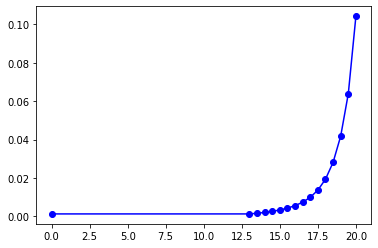

In [82]:
plt.plot(magvec, meserr_mas,'-bo')

In [83]:
noisediag = np.zeros(nmes)
idx0 = 0
n2 = int(nmes/2)
for c1 in range(3):
    sh_noise_rms = sh_interp_function(np.clip(mag[c1],np.min(magvec),np.max(magvec)))
    noisediag[idx0:idx0+nvl[c1]] = sh_noise_rms # noise in arcsec
    noisediag[idx0+n2:idx0+n2+nvl[c1]] = sh_noise_rms # noise in arcsec
    idx0 += nvl[c1]

In [84]:
noisediag.shape

(7272,)

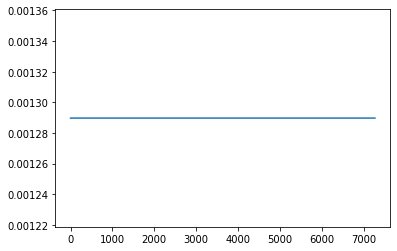

In [85]:
plt.plot(noisediag)

In [86]:
poke = 5e-6 #how much we change the DOF below in determinating the sensititivy matrix.
Rxyz = [3,4,5,9,10,11]# modes are M1S1Rxyz and M2S1Rxyz
nmodes = 82
H = np.zeros((nmes,nmodes))

~gmt
for k in Rxyz:
    modes = np.zeros(nmodes)
    modes[k] = poke
    modestogmtstate(gmt,modes)
    ~wfs
    gs>>(gmt,wfs)
    +gs
    +wfs
    mes = wfs.get_measurement()
    H[:,k] = mes/poke

In [87]:
H.shape

(7272, 82)

In [88]:
H = H[:,Rxyz]
#penmat = np.eye(6)*1e-7*0.
#Hinv = np.linalg.solve(np.transpose(H)@H+penmat,np.transpose(H))
Hinv = np.linalg.solve(np.transpose(H)@H,np.transpose(H))
Cnn = np.diag(noisediag) #this is where the noise gets in

J = np.trace(Hinv@Cnn@np.transpose(Hinv))
res[ast] = J

The diagonal elements of a covariance matrix are the variance of that element. For example, for the noise covariance matrix Cnn, the diagonal terms represent the variance of the noise of each measurement. Hinv@Cnn@Hinv.T is the reconstructed noise. The variance of each reconstructed mode is the diagonal element of this matrix. The trace is thus the sum of the variance, and it is the quantity we are trying to minimize.

In [89]:
print(H.shape, Hinv.shape, Cnn.shape, J.shape)

(7272, 6) (6, 7272) (7272, 7272) ()


In [90]:
J

5869.340796280996

In [91]:
res

array([5869.34079628,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ])

## Now loop over all the asterisms

In [92]:
for ast in range(nAsterism):
    gsidx = results['aco'][ast]
    pos = gspos[gsidx,:]
    zen = [np.hypot(pos[i,0],pos[i,1])/206265. for i in range(3)]
    azi = [np.arctan2(pos[i,0],pos[i,1]) for i in range(3)]
    mag = vismag[gsidx]

    gs = ceo.Source(photometric_band="R+I",zenith=zen,azimuth=azi,magnitude=np.array([10,10,10]),rays_box_size=L,rays_box_sampling=nLenslet*8+1,rays_origin=[0,0,25])

    # run my own calibration, because the interaction matrix is not consistent with the measured values
    gs.reset()
    gmt.reset()
    gmt.propagate(gs)
    wfs.calibrate(gs,threshold)
    gs>>(gmt,wfs)
    nmes = len(wfs.get_measurement())
    nvl = np.sum(wfs.valid_lenslet.f.host(shape=(3,48**2))>0,axis=1)

    magvec = np.array([0,13,13.5,14,14.5,15,15.5,16,16.5,17,17.5,18,18.5,19,19.5,20])

    # this is the error in the segment tip-tilt estimate using a 24x24 SH WFS
    meserr_for_800mas = np.array([0.00136217,0.00136217,0.00171104,0.00216745,0.00275779,0.00351932,0.00453948,0.00590709,0.00780148,0.0104783,0.0144437,0.0204345,0.0296933,0.044133,0.0674427,0.110046]) # measurement error per subaperture
    meserr_mas = meserr_for_800mas*seeingArcsec/0.8
    sh_interp_function = scipy.interpolate.interp1d(magvec,meserr_mas,bounds_error=False)

    noisediag = np.zeros(nmes)
    idx0 = 0
    n2 = int(nmes/2)
    for c1 in range(3):
        sh_noise_rms = sh_interp_function(np.clip(mag[c1],np.min(magvec),np.max(magvec)))
        noisediag[idx0:idx0+nvl[c1]] = sh_noise_rms # noise in arcsec
        noisediag[idx0+n2:idx0+n2+nvl[c1]] = sh_noise_rms # noise in arcsec
        idx0 += nvl[c1]

    poke = 5e-6
    Rxyz = [3,4,5,9,10,11]# modes are M1S1Rxyz and M2S1Rxyz
    nmodes = 82
    H = np.zeros((nmes,nmodes))

    ~gmt
    for k in Rxyz:
        modes = np.zeros(nmodes)
        modes[k] = poke
        modestogmtstate(gmt,modes)
        ~wfs
        gs>>(gmt,wfs)
        +gs
        +wfs
        mes = wfs.get_measurement()
        H[:,k] = mes/poke

    H = H[:,Rxyz]
    #penmat = np.eye(6)*1e-7*0.
    #Hinv = np.linalg.solve(np.transpose(H)@H+penmat,np.transpose(H))
    Hinv = np.linalg.solve(np.transpose(H)@H,np.transpose(H))
    Cnn = np.diag(noisediag)

    J = np.trace(Hinv@Cnn@np.transpose(Hinv))
    res[ast] = J

In [93]:
res

array([ 5869.34079628,  6765.41654215,  4137.73479822,  4600.99768258,
        4221.65868931,  4284.60053529,  4379.11300162,  4534.55890408,
        6395.7442486 ,  6350.89283892,  6564.20488467,  5128.94042102,
        5244.70223165,  5250.5978097 ,  5528.45536207, 10182.18199152,
        5393.27423436, 11376.63320963,  9620.55136529,  8635.57287115,
        4815.19261776,  6727.93518995,  5540.32377897,  5869.71217635,
        4827.05248898,  4605.53836554,  4521.92585602,  5175.81170766,
        4370.28481489,  4538.42163354,  4474.08357898,  4685.81855803,
        6570.5410708 ,  4860.79106958,  5339.39454884,  3737.16149916,
        4507.0850783 ])

In [94]:
np.argsort(res)

array([35,  2,  4,  5, 28,  6, 30, 36, 26,  7, 29,  3, 25, 31, 20, 24, 33,
       11, 27, 12, 13, 34, 16, 14, 22,  0, 23,  9,  8, 10, 32, 21,  1, 19,
       18, 15, 17])

In [95]:
#we will chose the asterism with the smallest trace of the Jacobian?
sidx = np.argsort(res)[0]

In [96]:
sidx

35

In [97]:
results

{'minangle': [84.59688561667778,
  62.43831391931119,
  84.59688561667778,
  62.43831391931119,
  83.08053955566761,
  77.96520820830345,
  77.96520820830345,
  77.96520820830345,
  85.5520709883657,
  85.5520709883657,
  85.5520709883657,
  88.765965420324,
  88.765965420324,
  88.765965420324,
  88.765965420324,
  39.76664747809484,
  84.59688561667778,
  32.67814347856482,
  32.67814347856482,
  39.76664747809484,
  77.96520820830345,
  85.5520709883657,
  88.765965420324,
  88.765965420324,
  94.54399001880212,
  75.89959678844146,
  92.89971233483145,
  108.0827136232962,
  109.08028120184814,
  108.0827136232962,
  95.86353910674228,
  108.0827136232962,
  108.0827136232962,
  111.25288548903498,
  110.15886169629081,
  91.91594421603428,
  91.91594421603428],
 'minradius': [495.3089973592513,
  407.6670571255215,
  534.4166907891071,
  407.6670571255215,
  534.4166907891071,
  542.3257591412232,
  542.3257591412232,
  542.3257591412232,
  370.41228957099133,
  370.41228957099133

In [98]:
#this was initialized to be all Nones.
probefunction

[None, None, None, None]

In [99]:
validpos[results['tt7'][sidx]].tolist()

688

In [100]:
tt7star = validpos[results['tt7'][sidx]].tolist()
acostars = validpos[results['aco'][sidx]].tolist()

tt7probe = results['tt7probe'][sidx]
acoprobes = results['acoprobes'][sidx]

probefunction[tt7probe] = 'tt7'
gsno[tt7probe] = int(tt7star)
vismaggs[tt7probe] = vismag[results['tt7'][sidx]]
xposgs[tt7probe] = xposarcsec[results['tt7'][sidx]]
yposgs[tt7probe] = yposarcsec[results['tt7'][sidx]]

In [101]:
acoprobes

array([0, 1, 2])

In [102]:
results['acoprobes']

[array([1, 2, 3]),
 array([1, 2, 3]),
 array([1, 2, 3]),
 array([1, 2, 3]),
 array([1, 2, 3]),
 array([1, 2, 3]),
 array([1, 2, 3]),
 array([1, 2, 3]),
 array([1, 2, 3]),
 array([1, 2, 3]),
 array([1, 2, 3]),
 array([1, 2, 3]),
 array([1, 2, 3]),
 array([1, 2, 3]),
 array([1, 2, 3]),
 array([1, 2, 3]),
 array([1, 2, 3]),
 array([0, 1, 2]),
 array([0, 1, 2]),
 array([0, 1, 2]),
 array([0, 1, 2]),
 array([0, 1, 2]),
 array([0, 1, 2]),
 array([0, 1, 2]),
 array([0, 1, 2]),
 array([0, 1, 2]),
 array([0, 1, 2]),
 array([0, 1, 2]),
 array([0, 1, 2]),
 array([0, 1, 2]),
 array([0, 1, 2]),
 array([0, 1, 2]),
 array([0, 1, 2]),
 array([0, 1, 2]),
 array([0, 1, 2]),
 array([0, 1, 2]),
 array([0, 1, 2])]

In [103]:
acostars

[1808, 1828, 1872]

In [104]:
for idx,k in enumerate(acoprobes.tolist()):
    probefunction[k] = 'aco'
    gsno[k] = int(acostars[idx])
    vismaggs[k] = vismag[results['aco'][sidx][idx]]
    xposgs[k] = xposarcsec[results['aco'][sidx][idx]]
    yposgs[k] = yposarcsec[results['aco'][sidx][idx]]

bestasterism = {'Probe number': [0,1,2,3], 'Probe function': probefunction,'Guide star':gsno,
                'Visible magnitude':vismaggs,'xpos':xposgs,'ypos':yposgs}

In [105]:
bestasterism

{'Probe number': [0, 1, 2, 3],
 'Probe function': ['aco', 'aco', 'aco', 'tt7'],
 'Guide star': [1808, 1828, 1872, 688],
 'Visible magnitude': [13.082380194104847,
  10.8887131274574,
  12.266086334898494,
  9.975453234116225],
 'xpos': [206.59294064250878,
  -409.9081771514453,
  552.5198356850545,
  337.6600620393033],
 'ypos': [551.1147972714898,
  -424.3352433153763,
  -228.46750399476056,
  143.64809500000047]}

In [106]:
outputfilename

'/home/ubuntu/PYTHON/AGWS/Fields/m3_asterism_0000.csv'

In [107]:
! ls /home/ubuntu/PYTHON/AGWS/Fields/*_0000.csv

/home/ubuntu/PYTHON/AGWS/Fields/dgwf_asterism_0000.csv
/home/ubuntu/PYTHON/AGWS/Fields/field_0000.csv
/home/ubuntu/PYTHON/AGWS/Fields/m3_asterism_0000.csv


In [108]:
# report the best asterism
print(outputfilename)
df = pd.DataFrame(bestasterism,index=None)
print (df)
df.to_csv(outputfilename, index = False, header=True)

/home/ubuntu/PYTHON/AGWS/Fields/m3_asterism_0000.csv
   Probe number Probe function  Guide star  Visible magnitude        xpos  \
0             0            aco        1808          13.082380  206.592941   
1             1            aco        1828          10.888713 -409.908177   
2             2            aco        1872          12.266086  552.519836   
3             3            tt7         688           9.975453  337.660062   

         ypos  
0  551.114797  
1 -424.335243  
2 -228.467504  
3  143.648095  
